<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Соревнование Kaggle "Catch Me If You Can"

Будем решать задачу идентификации взломщика по его поведению в сети Интернет. 

Нужно проанализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

In [1]:
from __future__ import division
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from collections import Counter
import datetime
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
PATH_TO_DATA = '/Users/cross/Documents/coursera/Yandex_ML/course6/kaggle' 

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [6]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
По условиям соревнования сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. Это немного ограничивает наши возможности, т.к. более длинные сессия по количеству сайтов могуть дать нам лучшие результаты.

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


In [9]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, при разбиении обязательно нужно будет стратифицировать выборки. **

** Индексы сайтов нумеровались с 1, так что можно заменить пропуски на нули.**

In [10]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [11]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


** Посмотрим на корреляцию признаков "siteN" и id пользователя **

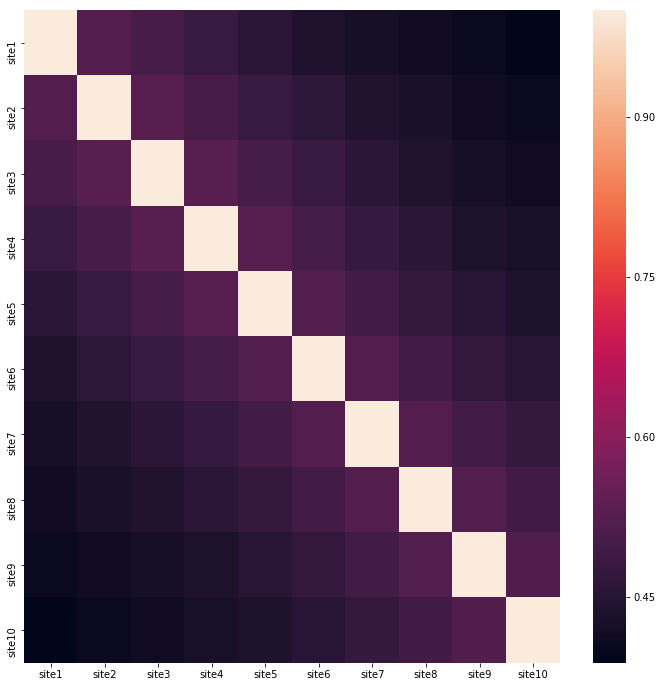

In [12]:
plt.figure(figsize=(12, 12))
sns.heatmap(train_test_df[['site%d' % i for i in range(1, 11)]].corr())
plt.show()

** Как видим некоторая корреляция присутствует. Можно попробовать создать первые модели**

**Для построение моделей создадим разреженные матрицы *X_train_sparse* и *X_test_sparse* **

В  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

In [13]:
def create_csr_matrix(data):
    indexes = [0]
    vals = []
    column_indexes = []
    index = 0
    for i in range(0,data.shape[0]):
        for j in range(0, data.shape[1]):
            if data[i,j] != 0:
                column_indexes.append(data[i,j])
                vals.append(1)
                index+=1
        indexes.append(index)
    return csr_matrix((vals, column_indexes, indexes))[:,1:]

train_test_sparse = create_csr_matrix(train_test_df_sites.as_matrix())
X_train_sparse = train_test_sparse[:253561]
X_test_sparse = train_test_sparse[253561:]
y = train_df['target'].as_matrix()

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [14]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

** Создадим класс StratifiedKFold c 3 фолдами который будем использовать для сравнения моделей по кросс-валидации **

In [15]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Начнем с `sklearn.linear_model.SGDClassifier` с логистической функцией потерь. Один из наиболее быстрых способов.**

In [16]:
%%time
sgd_logit = SGDClassifier(random_state=17, n_jobs=-1, loss='log')
sgd_logit.fit(X_train, y_train)

CPU times: user 267 ms, sys: 4.21 ms, total: 271 ms
Wall time: 270 ms


** Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*. Посмотрим на ROC_AUC логистической регрессии и cross_val_score, обученной с помощью стохастического градиентного спуска, на отложенной выборке.**

In [17]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
print "Roc_auc score for SGDClasifier is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "Cross val score for SGDClassifier:", cross_val_score(sgd_logit, X_train_sparse,
                                                                                  y, n_jobs=-1, scoring='roc_auc', cv=skf)



Roc_auc score for SGDClasifier is : 0.933847823591
Cross val score for SGDClassifier: [ 0.93837926  0.93370595  0.9386594 ]


**Также сделаем прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке.**

In [18]:
%%time
sgd_logit = SGDClassifier(random_state=17, n_jobs=-1, loss='log').fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

CPU times: user 437 ms, sys: 17.7 ms, total: 455 ms
Wall time: 453 ms


**Запишим ответы в файл и сделаем посылку на Kaggle. **

In [19]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [20]:
write_to_submission_file(logit_test_pred_proba[:,1], os.path.join(PATH_TO_DATA, 'kaggle_submission.csv'))

** По условиям соревнования модели сравниваются по roc_auc. Наша посылка имела значение - 0.91273. Это немного ниже чем значение на нашей отложенной выборке и значение полученное через cross_val_score, но при этом достаточно близкое. **

** Создадим несколько признаков которые могут улучшить модель из данных которые есть в изначальном датасете **

In [21]:
new_feature_df = pd.DataFrame()

** Добавим признак количество посещенных уникальных сайтов за сессию. **

In [22]:
%%time
new_feature_df['uniq_sites'] = train_test_df_sites.apply(lambda x: len(np.unique(x[:10])), axis=1)

CPU times: user 28.5 s, sys: 53.4 ms, total: 28.5 s
Wall time: 28.5 s


In [23]:
new_feature_df.head()

,uniq_sites
session_id,
1,2
2,7
3,4
4,1
5,4


** Аналогично добавим признак количество посещенных "популярных" сайтов из top 50. **

In [24]:
%%time
counter = train_test_df_sites.stack().value_counts()
top_sites = counter[1:50].index
def count_popular(row):
    return len(set(row[:10]) & set(top_sites))

new_feature_df['top_sites_visited'] = train_test_df_sites.apply(count_popular, axis=1)

CPU times: user 31.9 s, sys: 1.19 s, total: 33.1 s
Wall time: 32.4 s


** Аналогично добавим признаки "час начала сессии" и "день недели начала сессии" "Длина сессии в секундах", и время посещения каждого сайта **

In [25]:
%%time
def get_start_hour(x):
    return datetime.datetime.strptime(x[0], "%Y-%m-%d %H:%M:%S").hour

new_feature_df['start_hour'] = train_test_df[['time1']].apply(get_start_hour, axis=1)

CPU times: user 14.1 s, sys: 83 ms, total: 14.2 s
Wall time: 14.2 s


In [26]:
%%time
def get_start_day_of_week(x):
    return datetime.datetime.strptime(x[0], "%Y-%m-%d %H:%M:%S").weekday()
new_feature_df['day_of_week'] = train_test_df[['time1']].apply(get_start_day_of_week, axis=1)

CPU times: user 16.1 s, sys: 101 ms, total: 16.2 s
Wall time: 16.2 s


In [27]:
def get_session_timespan(row):
    start_time = row[0];
    end_time = row[0];
    for r in row:
        if r == 0:
            continue
        end_time = r
    start_time = datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    end_time = datetime.datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    return (end_time - start_time).total_seconds()

new_feature_df['ses_timespan'] = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0).apply(get_session_timespan, axis=1)

In [28]:
%%time
def get_visits_time(row):
    start_time = row[0];
    end_time = row[0];
    res = []
    for r in row:
        if r == 0:
            break
        start_time = end_time
        end_time = r
        s_time = datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
        e_time = datetime.datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
        res.append((e_time - s_time).total_seconds())
    while(len(res) < 10):
        res.append(0)
    return res[1],res[2],res[3],res[4],res[5],res[6],res[7],res[8],res[9]

temp = list(zip(*train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0).apply(get_visits_time, axis=1)))
for i, c in enumerate(['time_diff%d' % i for i in range(1, 10)]):
    new_feature_df[c] = temp[i]

CPU times: user 2min 16s, sys: 959 ms, total: 2min 17s
Wall time: 2min 17s


In [29]:
new_feature_df.head()

,uniq_sites,top_sites_visited,start_hour,day_of_week,ses_timespan,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
session_id,,,,,,,,,,,,,,
1,2,0,10,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,2,11,5,26.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0
3,4,2,16,0,7.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
4,1,1,10,4,270.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
5,4,3,10,4,246.0,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0


** Посмотрим на гистограммы распределения новых признаков **

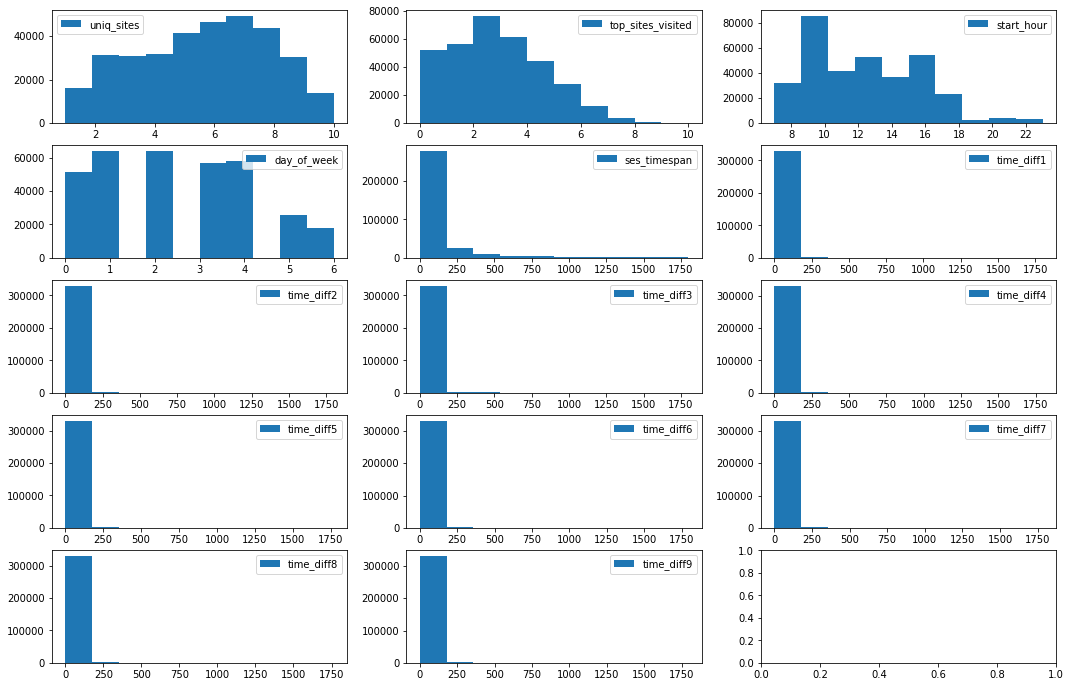

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 12))

for idx, colname in  enumerate(new_feature_df.columns): 
    ax = axes[int(idx/3)][idx%3]
    ax.hist(new_feature_df[colname])
    ax.set_label(colname)
    ax.legend([colname])

** Добавим колонку с user_id и посмотрим кореляцию признаков с ним. **

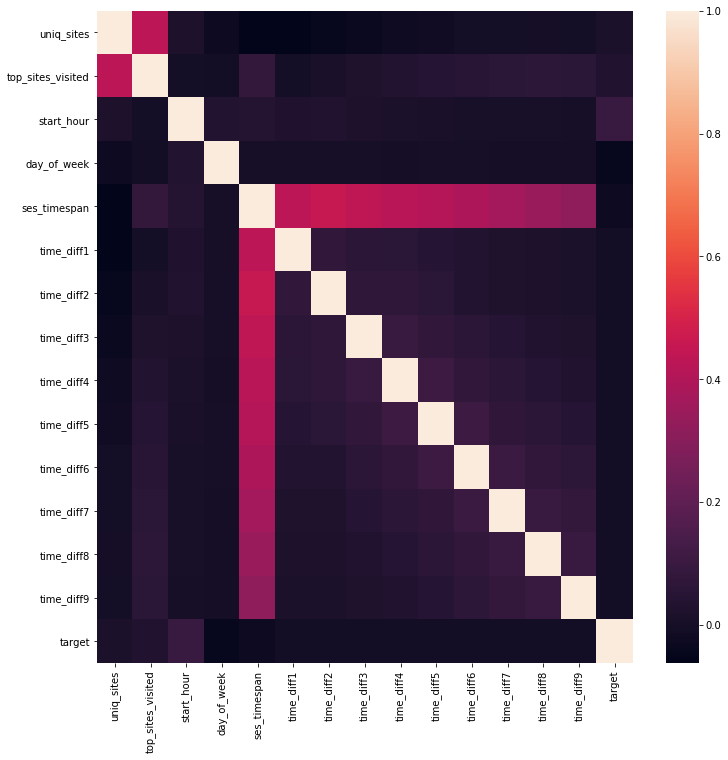

In [31]:
new_feature_df['target'] = train_test_df['target']
plt.figure(figsize=(12, 12))
sns.heatmap(new_feature_df.corr())
plt.show()
new_feature_df = new_feature_df.drop('target', axis=1)

** Как видим наибольшую кореляцию с целевой меткой у нас имеет признак start_hour. Обьеденим наши новые признаки с признаками посещенных сайтов. **

In [32]:
from scipy.sparse import hstack
new_feature_train = new_feature_df.as_matrix()[:253561]
new_feature_test = new_feature_df.as_matrix()[253561:]
new_feature_train_sparse = csr_matrix(new_feature_train)
new_feature_test_sparse = csr_matrix(new_feature_test)

X_train_sparse_with_new = csr_matrix(hstack([X_train_sparse, new_feature_train_sparse]))
X_test_sparse_with_new = csr_matrix(hstack([X_test_sparse, new_feature_test_sparse]))

X_train, y_train = X_train_sparse_with_new[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_with_new[train_share:, :], y[train_share:]

** Попробуем обучить SGDClassifier  с новыми признаками и посмотрим улучшают ли они его качество. Смотреть будем на roc_auc на отложенной выборке и на cross_val_score **

In [33]:
n_f = len(new_feature_df.columns)
for i in reversed(range(1,len(new_feature_df.columns) + 1)):
    sgd_logit = SGDClassifier(random_state=17, n_jobs=-1, loss='log')
    sgd_logit.fit(X_train[:,:-i], y_train)
    logit_valid_pred_proba = sgd_logit.predict_proba(X_valid[:,:-i])
    print "Roc_auc score for SGDClasifier(with ", n_f - i, " feature) is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
    print "mean cross_val_score:", np.mean(cross_val_score(sgd_logit, X_train_sparse_with_new[:,:-i],
                                                                                  y, n_jobs=-1, scoring='roc_auc', cv=skf))

Roc_auc score for SGDClasifier(with  0  feature) is : 0.933847286791
mean cross_val_score: 0.936914876491
Roc_auc score for SGDClasifier(with  1  feature) is : 0.920440142464
mean cross_val_score: 0.897156881187
Roc_auc score for SGDClasifier(with  2  feature) is : 0.915706518701
mean cross_val_score: 0.899999452861
Roc_auc score for SGDClasifier(with  3  feature) is : 0.907966494586
mean cross_val_score: 0.873767070802
Roc_auc score for SGDClasifier(with  4  feature) is : 0.915954836962
mean cross_val_score: 0.892586961892
Roc_auc score for SGDClasifier(with  5  feature) is : 0.706293119956
mean cross_val_score: 0.724503348389
Roc_auc score for SGDClasifier(with  6  feature) is : 0.708394100453
mean cross_val_score: 0.698208645747
Roc_auc score for SGDClasifier(with  7  feature) is : 0.695062990113
mean cross_val_score: 0.688026018031
Roc_auc score for SGDClasifier(with  8  feature) is : 0.671866910845
mean cross_val_score: 0.665222226312
Roc_auc score for SGDClasifier(with  9  featur

** Как видим простое добавление признаков ухудшает модель. Попробуем преобразовать признаки uniq_sites, top_sites_visited, start_hour, day_of_week как будто они категориальные, заменим их на набор признаков name\_(0-10)  **

In [34]:
new_feature_df_cat = new_feature_df[['uniq_sites', 'top_sites_visited', 'start_hour', 'day_of_week']]
uniq_dumies = pd.get_dummies(new_feature_df_cat['uniq_sites'], prefix='uniq_sites')
new_feature_df_cat = pd.concat([new_feature_df_cat, uniq_dumies],axis=1)
new_feature_df_cat.drop('uniq_sites', axis=1, inplace=True)

top_dumies = pd.get_dummies(new_feature_df_cat['top_sites_visited'], prefix='top_sites_visited')
new_feature_df_cat = pd.concat([new_feature_df_cat, top_dumies],axis=1)
new_feature_df_cat.drop('top_sites_visited', axis=1, inplace=True)

hour_dumies = pd.get_dummies(new_feature_df_cat['start_hour'], prefix='start_hour')
new_feature_df_cat = pd.concat([new_feature_df_cat, hour_dumies],axis=1)
new_feature_df_cat.drop('start_hour', axis=1, inplace=True)

day_dumies = pd.get_dummies(new_feature_df_cat['day_of_week'], prefix='day_of_week')
new_feature_df_cat = pd.concat([new_feature_df_cat, day_dumies], axis=1)
new_feature_df_cat.drop('day_of_week', axis=1, inplace=True)

** Полученные таким образом дополнительные признаки добавим к признакам посещенных сайтов **

In [35]:
new_feature_train = new_feature_df_cat.as_matrix()[:253561]
new_feature_test = new_feature_df_cat.as_matrix()[253561:]
new_feature_train_sparse = csr_matrix(new_feature_train)
new_feature_test_sparse = csr_matrix(new_feature_test)

X_train_sparse_with_new = csr_matrix(hstack([X_train_sparse, new_feature_train_sparse]))
X_test_sparse_with_new = csr_matrix(hstack([X_test_sparse, new_feature_test_sparse]))

X_train, y_train = X_train_sparse_with_new[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_with_new[train_share:, :], y[train_share:]
print "Size of train set is ", X_train_sparse_with_new.shape

Size of train set is  (253561, 48416)


In [36]:
sgd_logit = SGDClassifier(random_state=17, n_jobs=-1, loss='log')
sgd_logit.fit(X_train, y_train)
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
print "Roc_auc score for SGDClasifier(with ", n_f - i, " feature) is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(sgd_logit, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

Roc_auc score for SGDClasifier(with  13  feature) is : 0.971491990051
mean cross_val_score: 0.974202586132


** Как видим в таком варианте признаки достаточно сильно улучшили нашу модель. Такая модель в соревновании на kaggle будет иметь 0.93619 roc_auc score **

** Можно попробовать другие модели и сравнить с SGDClassifier ** 

In [37]:
%%time
estimator = LogisticRegressionCV(random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for LogisticRegressionCV is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

Roc_auc score for LogisticRegressionCV is : 0.985719011204
mean cross_val_score: 0.987538108938
CPU times: user 3.37 s, sys: 341 ms, total: 3.71 s
Wall time: 58.3 s


In [38]:
%%time
from sklearn.svm import LinearSVC
svm_params = {'C': np.linspace(1, 3, 10)}
svm_grid_searcher =  GridSearchCV(LinearSVC(C=1, random_state=17), svm_params, cv=skf, scoring='roc_auc', n_jobs=-1)
svm_grid_searcher.fit(X_train_sparse_with_new, y)
print "Best score and params for SVM", svm_grid_searcher.best_score_, svm_grid_searcher.best_params_ 

Best score and params for SVM 0.984238389719 {'C': 1.0}
CPU times: user 8.16 s, sys: 338 ms, total: 8.5 s
Wall time: 44.1 s


In [39]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for RandomForestClassifier is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

Roc_auc score for RandomForestClassifier is : 0.922099220941
mean cross_val_score: 0.91736554112


** Как видим один из лучших результатов дает нам метод LogisticRegressionCV с набором данных с категореальными признаками **
** Его результат на public leader board kaggle - 0.94199 ** 

** Простое добавление признаков с временем не давало нам улучшения модели, скорее всего это было из-за большой разницы в величинах. Попробуем нормировать их с помощью sklearn.preprocessing.StandartScaler  и проверим как это скажется на качестве наших моделей. Будем смотреть сразу на три варианта.**

In [40]:
%%time
new_feature_df_time = new_feature_df.drop(['uniq_sites', 'top_sites_visited', 'start_hour', 'day_of_week'], axis=1)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
new_feature_df_time_sc = sc.fit_transform(new_feature_df_time)

new_feature_train = new_feature_df_time_sc[:253561]
new_feature_test = new_feature_df_time_sc[253561:]
new_feature_train_sparse = csr_matrix(new_feature_train)
new_feature_test_sparse = csr_matrix(new_feature_test)

X_train_sparse_with_new = csr_matrix(hstack([X_train_sparse, new_feature_train_sparse]))
X_test_sparse_with_new = csr_matrix(hstack([X_test_sparse, new_feature_test_sparse]))

X_train, y_train = X_train_sparse_with_new[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_with_new[train_share:, :], y[train_share:]


print "Size of train set is ", X_train_sparse_with_new.shape

estimator = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for SGDClasifier with with time is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))


estimator = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for RandomForestClassifier with time is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

estimator = LogisticRegressionCV(random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for LogisticRegressionCV with time is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

Size of train set is  (253561, 48381)
Roc_auc score for SGDClasifier with with time is : 0.907084559763
mean cross_val_score: 0.906617043115
Roc_auc score for RandomForestClassifier with time is : 0.817255685314
mean cross_val_score: 0.812427111262
Roc_auc score for LogisticRegressionCV with time is : 0.959033525966
mean cross_val_score: 0.961252622783
CPU times: user 1min 19s, sys: 1.31 s, total: 1min 21s
Wall time: 1min 51s


** Видим что для SGDClassifier и RandomForestClassifier добавление этих признаков не принесло пользы. Однако для LogisticRegression добавление этих признаков дает улучшение результатов. **
** Можно попробовать обьеденить эти признаки с категориальными и посмотреть на результат **

In [41]:
%%time
new_feature_train = new_feature_df_cat[:253561]
new_feature_test = new_feature_df_cat[253561:]
new_feature_train_sparse = csr_matrix(new_feature_train)
new_feature_test_sparse = csr_matrix(new_feature_test)

X_train_sparse_with_new_cat = csr_matrix(hstack([X_train_sparse, new_feature_train_sparse]))
X_test_sparse_with_new_cat = csr_matrix(hstack([X_test_sparse, new_feature_test_sparse]))


new_feature_train = new_feature_df_time_sc[:253561]
new_feature_test = new_feature_df_time_sc[253561:]
new_feature_train_sparse_sc = csr_matrix(new_feature_train)
new_feature_test_sparse_sc = csr_matrix(new_feature_test)


X_train_sparse_with_new = csr_matrix(hstack([X_train_sparse_with_new_cat, new_feature_train_sparse_sc]))
X_test_sparse_with_new = csr_matrix(hstack([X_test_sparse_with_new_cat, new_feature_test_sparse_sc]))

X_train, y_train = X_train_sparse_with_new[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_with_new[train_share:, :], y[train_share:]

print "Size of train set is ", X_train_sparse_with_new.shape

estimator = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for SGDClasifier with with time and cat is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))


estimator = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for RandomForestClassifier with time and cat is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

estimator = LogisticRegressionCV(random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for LogisticRegressionCV with time and cat is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

Size of train set is  (253561, 48426)
Roc_auc score for SGDClasifier with with time and cat is : 0.971811635708
mean cross_val_score: 0.974683360774
Roc_auc score for RandomForestClassifier with time and cat is : 0.901958937276
mean cross_val_score: 0.90130761919
Roc_auc score for LogisticRegressionCV with time and cat is : 0.985656148005
mean cross_val_score: 0.987570645539
CPU times: user 1min 1s, sys: 1.56 s, total: 1min 2s
Wall time: 1min 42s


** LogisticRegressionCV дает чуть чуть лучший результат чем с просто категореальными признаками. SGDClasifier получил достаточно большой буст. Сохраним предсказания для этих моделей на test выборке** 

In [42]:
%%time
print "Size of train set is ", X_train_sparse_with_new.shape
estimator = LogisticRegressionCV(random_state=17, n_jobs=-1)
estimator.fit(X_train_sparse_with_new, y)
test_pred = estimator.predict_proba(X_test_sparse_with_new)
write_to_submission_file(test_pred[:,1], os.path.join(PATH_TO_DATA, 'kaggle_submission_LogisticRegressionCV_time_cat.csv'))
#0.94193 on kaggle

estimator = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
estimator.fit(X_train_sparse_with_new, y)
test_pred = estimator.predict_proba(X_test_sparse_with_new)
write_to_submission_file(test_pred[:,1], os.path.join(PATH_TO_DATA, 'kaggle_submission_SGDClassifier_time_cat.csv'))
#0.93787 on kaggle

Size of train set is  (253561, 48426)
CPU times: user 4.2 s, sys: 244 ms, total: 4.45 s
Wall time: 24.4 s


** Для логистической регресии можно попробовать подобрать параметры ** 

In [43]:
%%time
logit_c_values = np.linspace(1, 4, 30)
log_reg = LogisticRegressionCV(Cs=logit_c_values, random_state=17, n_jobs=-1).fit(X_train_sparse_with_new,y)
logit_mean_cv_scores1 = np.mean(log_reg.scores_.values()[0],axis=0)
print logit_mean_cv_scores1

[ 0.99380031  0.99387524  0.99392257  0.99393834  0.99396201  0.99398567
  0.9939975   0.99402511  0.99403694  0.99404088  0.99405666  0.99406454
  0.99406454  0.9940606   0.99404483  0.99404483  0.99404877  0.99403694
  0.99404483  0.99404088  0.99403299  0.99402905  0.99402905  0.99403694
  0.99403694  0.99403299  0.99403694  0.99404482  0.99405666  0.9940606 ]
CPU times: user 3.4 s, sys: 278 ms, total: 3.68 s
Wall time: 1min 23s


In [44]:
print "Best results with Cs=", logit_c_values[1]

Best results with Cs= 1.10344827586


In [45]:
%%time
estimator = LogisticRegressionCV(Cs=[2.10526315789], random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for LogisticRegressionCV with time and cat is :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))
estimator.fit(X_train_sparse_with_new, y)
test_pred = estimator.predict_proba(X_test_sparse_with_new)
write_to_submission_file(test_pred[:,1], os.path.join(PATH_TO_DATA, 'kaggle_submission_LogisticRegressionCV_time_cat_withCs.csv'))
#0.94400 on kaggle

Roc_auc score for LogisticRegressionCV with time and cat is : 0.985692209511
mean cross_val_score: 0.987318474066
CPU times: user 6.49 s, sys: 583 ms, total: 7.07 s
Wall time: 22.2 s


** Можно попробовать сделать смесь моделей. Например сделать LogisticRegressionCV c категориальными признаками и отдельно модель с временными признаками и потом усреднить результат. **

In [46]:
%%time
new_feature_train = new_feature_df_time_sc[:253561]
new_feature_test = new_feature_df_time_sc[253561:]
new_feature_train_sparse_sc = csr_matrix(new_feature_train)
new_feature_test_sparse_sc = csr_matrix(new_feature_test)

X_train, y_train = new_feature_train_sparse_sc[:train_share, :], y[:train_share]
X_valid, y_valid  = new_feature_train_sparse_sc[train_share:, :], y[train_share:]



print "Size of train set is ", new_feature_train_sparse_sc.shape

estimator = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
sgd_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for SGDClasifier with only time :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, new_feature_train_sparse_sc,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))


estimator = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)
estimator.fit(X_train, y_train)
forest_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for RandomForestClassifier with only time :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, new_feature_train_sparse_sc,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

estimator = LogisticRegressionCV(Cs=[2.10526315789], random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for LogisticRegressionCV with only time :", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, new_feature_train_sparse_sc,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))


print "------------------------------------------------------------------"

new_feature_train = new_feature_df_cat[:253561]
new_feature_test = new_feature_df_cat[253561:]
new_feature_train_sparse = csr_matrix(new_feature_train)
new_feature_test_sparse = csr_matrix(new_feature_test)

X_train_sparse_with_new_cat = csr_matrix(hstack([X_train_sparse, new_feature_train_sparse]))
X_test_sparse_with_new_cat = csr_matrix(hstack([X_test_sparse, new_feature_test_sparse]))

X_train, y_train = X_train_sparse_with_new_cat[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_with_new_cat[train_share:, :], y[train_share:]

print "Size of train set is ", X_train_sparse_with_new_cat.shape

estimator = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
sgd_valid_pred_proba2 = estimator.predict_proba(X_valid)
print "Roc_auc score for SGDClasifier with only time :", roc_auc_score(y_valid, sgd_valid_pred_proba2[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new_cat,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))


estimator = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)
estimator.fit(X_train, y_train)
forest_valid_pred_proba2 = estimator.predict_proba(X_valid)
print "Roc_auc score for RandomForestClassifier with only time :", roc_auc_score(y_valid, forest_valid_pred_proba2[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new_cat,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))

estimator = LogisticRegressionCV(Cs=[2.10526315789], random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba2 = estimator.predict_proba(X_valid)
print "Roc_auc score for LogisticRegressionCV with only time :", roc_auc_score(y_valid, logit_valid_pred_proba2[:,1])
print "mean cross_val_score:", np.mean(cross_val_score(estimator, X_train_sparse_with_new_cat,
                                                                              y, n_jobs=-1, scoring='roc_auc', cv=skf))



print "Result roc_auc:"
logit_av = (logit_valid_pred_proba[:,1] + logit_valid_pred_proba2[:,1])/2
sgd_av = (sgd_valid_pred_proba[:,1] + sgd_valid_pred_proba2[:,1])/2
forest_av = (forest_valid_pred_proba[:,1] + forest_valid_pred_proba2[:,1])/2
print "Roc_auc score for SGDClasifier average:", roc_auc_score(y_valid, sgd_av)
print "Roc_auc score for RandomForest average :", roc_auc_score(y_valid, forest_av)
print "Roc_auc score for LogisticRegressionCV average:", roc_auc_score(y_valid, logit_av)

Size of train set is  (253561, 10)
Roc_auc score for SGDClasifier with only time : 0.985692209511
mean cross_val_score: 0.611395071554
Roc_auc score for RandomForestClassifier with only time : 0.985692209511
mean cross_val_score: 0.527136075736
Roc_auc score for LogisticRegressionCV with only time : 0.611386752955
mean cross_val_score: 0.608581834062
------------------------------------------------------------------
Size of train set is  (253561, 48416)
Roc_auc score for SGDClasifier with only time : 0.971491990051
mean cross_val_score: 0.974202586132
Roc_auc score for RandomForestClassifier with only time : 0.922099220941
mean cross_val_score: 0.91736554112
Roc_auc score for LogisticRegressionCV with only time : 0.98559094589
mean cross_val_score: 0.987268632315
Result roc_auc:
Roc_auc score for SGDClasifier average: 0.966089838508
Roc_auc score for RandomForest average : 0.924334507061
Roc_auc score for LogisticRegressionCV average: 0.980679219317
CPU times: user 1min 39s, sys: 1.79 

** Как видно из вывода, такое смешение моделей не дает выигрыша в качестве модели, можно еще попробовать усреднить выходы разных класификаторов между собой **

In [47]:
%%time
new_feature_train = new_feature_df_cat[:253561]
new_feature_test = new_feature_df_cat[253561:]
new_feature_train_sparse = csr_matrix(new_feature_train)
new_feature_test_sparse = csr_matrix(new_feature_test)

X_train_sparse_with_new_cat = csr_matrix(hstack([X_train_sparse, new_feature_train_sparse]))
X_test_sparse_with_new_cat = csr_matrix(hstack([X_test_sparse, new_feature_test_sparse]))


new_feature_train = new_feature_df_time_sc[:253561]
new_feature_test = new_feature_df_time_sc[253561:]
new_feature_train_sparse_sc = csr_matrix(new_feature_train)
new_feature_test_sparse_sc = csr_matrix(new_feature_test)


X_train_sparse_with_new = csr_matrix(hstack([X_train_sparse_with_new_cat, new_feature_train_sparse_sc]))
X_test_sparse_with_new = csr_matrix(hstack([X_test_sparse_with_new_cat, new_feature_test_sparse_sc]))

X_train, y_train = X_train_sparse_with_new[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_with_new[train_share:, :], y[train_share:]

print "Size of train set is ", X_train_sparse_with_new.shape

estimator = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
sgd_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for SGDClasifier with all :", roc_auc_score(y_valid, sgd_valid_pred_proba[:,1])


estimator = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)
estimator.fit(X_train, y_train)
forest_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for RandomForestClassifier with all :", roc_auc_score(y_valid, forest_valid_pred_proba[:,1])

estimator = LogisticRegressionCV(Cs=[2.10526315789], random_state=17, n_jobs=-1)
estimator.fit(X_train, y_train)
logit_valid_pred_proba = estimator.predict_proba(X_valid)
print "Roc_auc score for LogisticRegressionCV with all:", roc_auc_score(y_valid, logit_valid_pred_proba[:,1])

all_av = (logit_valid_pred_proba[:,1] + forest_valid_pred_proba[:,1] + sgd_valid_pred_proba[:,1])/3
print "-------------------------------------------------------"
print "Roc_auc score for average all:", roc_auc_score(y_valid, all_av)


Size of train set is  (253561, 48426)
Roc_auc score for SGDClasifier with all : 0.971811635708
Roc_auc score for RandomForestClassifier with all : 0.901958937276
Roc_auc score for LogisticRegressionCV with all: 0.985692209511
-------------------------------------------------------
Roc_auc score for average all: 0.983262112659
CPU times: user 1min, sys: 1.07 s, total: 1min 1s
Wall time: 18.3 s


** Усреднение выходов разных класификаторов между собой тоже не принесло желаемого результата. Ради интереса можно проверить такое усреднение на тестовой выборке от kaggle**

In [48]:
estimator = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
estimator.fit(X_train_sparse_with_new, y)
sgd_valid_pred_proba = estimator.predict_proba(X_test_sparse_with_new)


estimator = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)
estimator.fit(X_train_sparse_with_new, y)
forest_valid_pred_proba = estimator.predict_proba(X_test_sparse_with_new)

estimator = LogisticRegressionCV(Cs=[2.10526315789], random_state=17, n_jobs=-1)
estimator.fit(X_train_sparse_with_new, y)
logit_valid_pred_proba = estimator.predict_proba(X_test_sparse_with_new)

all_av = (logit_valid_pred_proba[:,1] + forest_valid_pred_proba[:,1] + sgd_valid_pred_proba[:,1])/3
write_to_submission_file(all_av, os.path.join(PATH_TO_DATA, 'kaggle_submission_avv_all.csv'))
#0.93958 on kaggle

** Попробуем еще одну хорошую библиотеку классификации - Vowpal-wabbit. У нее свой формат входных данных, подготовим признаки для нее **

In [49]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    with open(os.path.join(PATH_TO_DATA, out_file), 'w') as vw_data:
        for index in range(0, X.shape[0]):
            line = ''
            if train == True:
                line += str(y[index]) + ' |'
            else:
                line += '1 | '
            for val in X[index]:
                line+= ' ' + str(int(val))
            line += '\n'
            vw_data.write(line)

In [50]:
from sklearn import preprocessing
y_to_vw = preprocessing.LabelEncoder().fit_transform(y) + 1
arrays_to_vw(train_test_df_sites.as_matrix()[:253561], y_to_vw)
arrays_to_vw(train_test_df_sites.as_matrix()[253561:], y_to_vw, out_file='test.vw')

In [51]:
print "my data"
!head -3 $PATH_TO_DATA/tmp.vw

my data
1 | 718 0 0 0 0 0 0 0 0 0
1 | 890 941 3847 941 942 3846 3847 3846 1516 1518
1 | 14769 39 14768 14769 37 39 14768 14768 14768 14768


** Обучение модели **

In [52]:
%%time
!vw -d $PATH_TO_DATA/tmp.vw --oaa 2 --passes 3 -b 26 --random_seed 17 -k\
   --cache_file $PATH_TO_DATA/cache.vw -f $PATH_TO_DATA/model.vw

final_regressor = /Users/cross/Documents/coursera/Yandex_ML/course6/kaggle/model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /Users/cross/Documents/coursera/Yandex_ML/course6/kaggle/cache.vw
Reading datafile = /Users/cross/Documents/coursera/Yandex_ML/course6/kaggle/tmp.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1        1       11
0.000000 0.000000            2            2.0        1        1       11
0.000000 0.000000            4            4.0        1        1       11
0.000000 0.000000            8            8.0        1        1       11
0.000000 0.000000           16           16.0        1        1       11
0.000000 0.000000           32           32.0        1        1       11
0.000000 0.000000           64           64.0       

** Сделаем предсказание для тестовой выборки **

In [53]:
%%time
!vw -d  $PATH_TO_DATA/test.vw -b 26 --random_seed 17 -t \
    -i $PATH_TO_DATA/model.vw -p $PATH_TO_DATA/pred.vw --probabilities

ignoring duplicate option: '--bit_precision 26'
only testing
predictions = /Users/cross/Documents/coursera/Yandex_ML/course6/kaggle/pred.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /Users/cross/Documents/coursera/Yandex_ML/course6/kaggle/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1   1(73%)       11
0.000000 0.000000            2            2.0        1   1(73%)       11
0.000000 0.000000            4            4.0        1   1(73%)       11
0.000000 0.000000            8            8.0        1   1(73%)       11
0.062500 0.125000           16           16.0        1   1(73%)       11
0.031250 0.000000           32           32.0        1   1(71%)       11
0.015625 0.000000           64           64.0        1   1(73%)       11
0.007812 0.000000  

** формат данных отличается, для того что бы была возможность отправки в kaggle требуется преборазование к формату соревнования **

In [54]:
!head -n 10 $PATH_TO_DATA/pred.vw

1:0.731059 2:0.268941
1:0.731059 2:0.268941
1:0.731059 2:0.268941
1:0.731059 2:0.268941
1:0.731059 2:0.268941
1:0.731059 2:0.268941
1:0.682496 2:0.317504
1:0.731059 2:0.268941
1:0.731059 2:0.268941
1:0.701628 2:0.298372


In [55]:
vw_df_pred = pd.DataFrame.from_csv(os.path.join(PATH_TO_DATA, 'pred.vw'), header=None, sep=' ')
pred = [float(x.split(':')[1]) for x in vw_df_pred.as_matrix()[:,0]]
write_to_submission_file(np.array(pred), os.path.join(PATH_TO_DATA, 'kaggle_submission_vowpal-wabbit.csv'))
#0.83735 on kaggle

** Как видно результат данного метода немного хуже чем результаты линейных методов. Но при сравнении нужно учитывать что пространство признаков в данной попытке было меньше чем в предыдущих методах. ** 

# Выводы:

** Задачей данного соревнования было выяснить возможно ли с достаточно точностью идентифицировать пользователя анализируя его предыдущую историю посещения сайтов в интернете за разумное время. Лучшая модель полученная мной в данном соревновании имеет точность на тестовой выборке 0.94400(4 место на public leaderboard kaggle момент написания). Такой результат был получен с применением метода логистической регрессии с учетом как истории посещенных сайтов пользователями в прошлом так и временных интервалов между посещениями. Так же в модель были добавлены синтетические признаки такие как:  ** 
- количество  посещенных уникальных сайтов за сессию,
- количество посещенных популярных среди данных пользователей сайтов,
- день недели и час начала сессии. 

** Обьединение разных моделей( путем усреднения вероятностей ) в данном случае не привело к увеличению точности идентификации пользователя. На практике можно попробовать и другие методы обьединения моделей, например "голосование" или усреднения с весами. **

** Так же для улучшения предсказаний можно попробовать ввести еще дополнительные признаки, например время посещения социальных сетей, принадлежит ли первый( и/или последний) сайт к социальным сетям или рабочим сайтам, время потраченное на соц. сети. Для улучшения моделей можно еще попробовать метод n-gram. **

** Для ускорения моделей так же можно использовать метод "главных компонент" для уменьшения признакового пространства и ускорения как обучения так и предсказания. Но в данном небольшом наборе данных такой необходимости нет ** 

** Данная модель может быть использована для идентификации не санкционировано доступа к аккаунту пользователей по анализу его поведения и сравнения с историческими данными **
